# Calculate Diffusion Coefficient

The Free Energy Profile F(q), fo radsorbate hopping aling the reaction coordinate can be calculated by the mean energy of insertion of the (spherical) adsorbate molecule using the FF parameters in the planes orthogonal to the reaction coordinate:
$$ F(q) = -k_BT ln\langle e^{-\beta \Delta U} \rangle_q $$
Here the brackets denote averaging the Boltzmann factor ocer the square grids of resolution dx Å resolution.

The 1-dim cage-to-cage hopping rate is given by: 
$$ k_{C_1 \rightarrow C_2} = \kappa \sqrt{\frac{k_B T}{2 \pi m}} \frac{e^{-\beta F(q^*)}}{\int_{cage} e^{-\beta F(q)} \,dq} $$
where m is the mass of the adsorbate, q is the reaction coordinate, F is the SOMETHING Free Energy as a function of the reaction coordinate, T is the temperature (T = 298 K), and $\kappa$ is the Bennett-Chandler dynamic correction. $\kappa$ = 1 is a good approximatin for infinite dilution. 
The space is partitioned such that the dividing surface is perpendicular to the reactin coordinate and passes through the location of the maximum free energy barrier along the path F(q*). 


To get the self-diffusion coefficient ($D_s$) 
$$ D_s = \frac{\kappa}{2d} \lambda^2 k_{C_1 \rightarrow C_2} $$

$\lambda$ is the cage-center to cage-center lattice distance.

### Outline
In this notebook, I am going to try to implement Transition State Theory (TST) to calculate the Self-Diffusion Coefficient of Xe and Kr in Ni(PyC)2 and Ni(PyC-m-NH2)2.

Helpful references include:
   1. [J. Phys. Chem. C 2016, 120, 2, 1110–1120](https://doi.org/10.1021/acs.jpcc.5b11111)
   2. [J. Chem. Phys. 122, 224712 (2005)](https://doi.org/10.1063/1.1924548)
   
Strategy:
   1. Load crystal, molecules, forcefield, ... 
   2. Perform `energy_grid()` calculation on each scructure for each adsorbate
   3. Define the reaction coordinate 
       a) find the location of the minimum free energy
       b) find the location of the minimum free energy in an adjacent pocket.
   4. Take "slices" of the free energy profile along the reaction coordinate.
   5. Perform integration using julia package [Cubature.jl](https://github.com/JuliaMath/Cubature.jl)
   6. Calculate cage-to-cage hopping rate $k_{C_1 \rightarrow C_2}$
   7. Calculate sel-difusion coefficient $D_s$

In [23]:
using PorousMaterials
using Statistics
using PyPlot
using Cubature
using Printf 

In [24]:
const R  = 8.31446261815324 / 1000 # Ideal Gas Constant, units: kJ/(mol-K)
const Nₐ = 6.022140 * 10^23 # Avogadro's Constant, units: mol⁻¹
temp = 298.0 # temperature, units: K
ljff = LJForceField("UFF")

adsorbates = Dict(:Xe => Dict(:molecule => Molecule("Xe"),
                               :mol_wgt => 131.293 / 1000), # kg/mol
                  :Kr => Dict(:molecule => Molecule("Kr"), 
                              :mol_wgt  => 83.798 / 1000),  # kg/mol
                  :Ar => Dict(:molecule => Molecule("Ar"), 
                              :mol_wgt  => 39.948 / 1000)   # kg/mol
                 )

xtals = Dict(:original    => Dict(:nipyc   => Crystal("NiPyC2_experiment.cif"),
                                  :nipycnh => Crystal("Pn_Ni-PyC-NH2.cif")), 
             :rep_factors => Dict(:nipyc   => (2, 1, 1), 
                                  :nipycnh => (1, 1, 2)),
             :replicated  => Dict{Symbol, Crystal}()
            )

xtals[:replicated][:nipyc]   = replicate(xtals[:original][:nipyc], xtals[:rep_factors][:nipyc])
xtals[:replicated][:nipycnh] = replicate(xtals[:original][:nipycnh], xtals[:rep_factors][:nipycnh])

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433
┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


Name: Pn_Ni-PyC-NH2.cif
Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 89.972000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 10.618000 Å. b = 11.878600 Å, c = 14.183600 Å
	Volume of unit cell: 1788.934346 Å³

	# atoms = 124
	# charges = 0
	chemical formula: Dict(:N => 4, :H => 10, :Ni => 1, :O => 4, :C => 12)
	space Group: P1
	symmetry Operations:
		'x, y, z'


# Grid Method

In [25]:
function free_energy_grid(x_id::Int, crystal::Crystal, 
                          temperature::Float64, bounds::Vector{Vector{Float64}})
    β = 1 / (R * temperature) # units: (kJ / mol)^-1
    
    # area to normalize sum
    # side_length = bounds_num_voxels * voxel_side_length
    #    where voxel_side_length = xtal_box_side_length / num_voxel_on_side
    ly = (bounds[2][2] - bounds[1][2]) * crystal.box.b / grid.n_pts[2]
    lz = (bounds[2][3] - bounds[1][3]) * crystal.box.c / grid.n_pts[3]
    area = ly * lz
    
    # grid id bounds of 2d sum
    lower_bounds_ids = xf_to_id(grid.n_pts, bounds[1])
    upper_bounds_ids = xf_to_id(grid.n_pts, bounds[2])
    bound_ids = [lower_bounds_ids, upper_bounds_ids]
    lb_y_id = bound_ids[1][2]
    lb_z_id = bound_ids[1][3]
    ub_y_id = bound_ids[2][2]
    ub_z_id = bound_ids[2][3]
    d1 = ub_y_id - lb_y_id 
    d2 = ub_z_id - lb_z_id
    
    # calculate average Boltzmann factor for a given q
    avg_btz_factor = mean(exp.(-β * grid.data[x_id, lb_y_id:ub_y_id, lb_z_id:ub_z_id]))
    
    return -1.0 / β * log(avg_btz_factor / area) # free energy, F(q), units: kJ/mol
end

free_energy_grid (generic function with 1 method)

In [26]:
# calculate vdW interaction energy on a grid 
res  = 0.1 # maximum distance between grid points, units: Å
grid = energy_grid(xtals[:replicated][:nipyc], adsorbates[:Xe][:molecule], 
                   ljff, resolution=res, units=:kJ_mol) 

# calculate Average Free energy along reaction coordinate
grid_free_E = Array{Float64, 1}()

for q_id in 1:grid.n_pts[1]
    # x-axis doesn't matter right now -> give dummy x bounds
    lower_bound = [0.0, 0.0, 0.5] # [fx, fy, fz]
    upper_bound = [0.0, 0.6, 0.99] # [fx, fy, fz] avoid periodic b.c. 0.0 = 1.0
    bounds = [lower_bound, upper_bound] 
    # store free energy calculation
    push!(grid_free_E, free_energy_grid(q_id, xtals[:replicated][:nipyc], temp, bounds))
end

Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 127 by 127 by 104 points superimposed over the unit cell.


LoadError: InterruptException:

### Calculate the Diffusin Coefficient

In [27]:
# get value and location of the maximum free energy
fe_q_str = maximum(grid_free_E)
q_str_id = findfirst(grid_free_E .== fe_q_str) 
q_str_xf = q_str_id * xtals[:replicated][:nipyc].box.a / grid.n_pts[1]

# get the locations of the minima
grd_fe_min = sortperm(grid_free_E)[1:2]
# check if indexes are on oposite sides of q_str_id
@assert grd_fe_min[1] < q_str_id "First free energy minimum not found before maximum."
@assert grd_fe_min[2] > q_str_id "Second free energy minimum not found after maximum."

println("Free Energy Barrier = $(fe_q_str - grid_free_E[grd_fe_min[1]]) kJ/mol")

###
#  Calculate hopping rate
###
κ = 1.0 # dynamic update factor units: num hops / unit time
β = 1 / (R * temp) # units: (kJ / mol)^-1
prefactor = sqrt(1 / (β * 2 * π * adsorbates[:Xe][:mol_wgt] / Nₐ))
# time_scale = λ / sqrt(1 / (β * 2 * π * adsorbates[:Xe][:mol_wgt] / Nₐ))
hop_rate = κ * prefactor * exp(-β * fe_q_str) / sum(exp.(-β * grid_free_E[1:q_str_id]))

println("Hopping rate = $(hop_rate) [ns⁻¹]")

###
#  Calculate Diffusion Coefficient
###
x = [i for i in 1:grid.n_pts[1]] * xtals[:replicated][:nipyc].box.a / grid.n_pts[1]
λ = x[grd_fe_min[2]] - x[grd_fe_min[1]] # distance between wells, units: Å
@assert λ < xtals[:replicated][:nipyc].box.a "distance between wells is more than xtal axis"

diff_coeff = (κ / 2) * λ^2 * hop_rate # units, ?? [Å²/ns]
println("Diffusion Coef = $() [Å² ns⁻¹]")

Free Energy Barrier = 18.185837509504424 kJ/mol
Hopping rate = 74106.08816015293 [ns⁻¹]


LoadError: syntax: unexpected ")"

### Plot Average Free Energy Along reaction Coordinate 

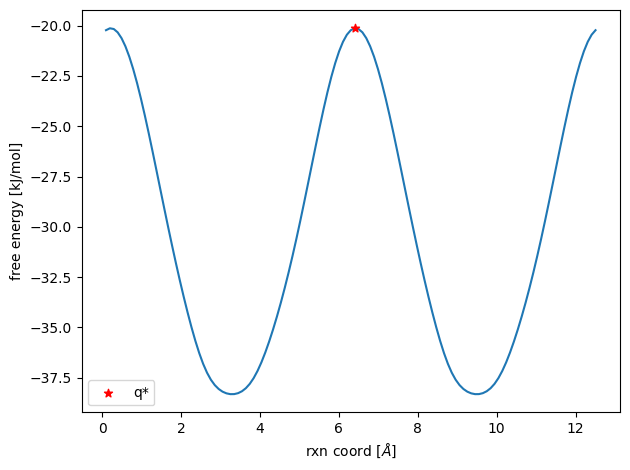

In [28]:
figure()

scatter([q_str_xf], [fe_q_str], label="q*", marker="*", color="r")
plot(x, grid_free_E, zorder=0)
legend()
ylabel("free energy [kJ/mol]")
xlabel("rxn coord " * L"[\AA]")
tight_layout()

**Use info from accessibility grid to determine reaction coordinate**

In [9]:
# grd_min_mol, grd_min_E = find_energy_minimum_gridsearch(rep_xtals[1], adsorbates[1], ljff, resolution=res)

# minimized_molecule, min_E = find_energy_minimum(rep_xtals[1], grd_min_mol, ljff)



# energy_tol = 50.0 # kJ/mol

# accessibility_grid, nb_segments_blocked, porosity = compute_accessibility_grid(rep_xtals[1], 
#                                                                         adsorbates[1], ljff; 
#                                                                         resolution=res, 
#                                                                         energy_tol=energy_tol, 
#                                                                         energy_units=:kJ_mol, 
#                                                                         verbose=true, 
#                                                                         write_b4_after_grids=false, 
#                                                                         block_inaccessible_pockets=true)



# function get_2d_integration_bounds(xtal::Crystal, energy_tol::Float64)
#     # maybe try to use the accessibility grid with a high resolution
#     # lb_y = 0.0
#     # lb_z = 0.0
#     # ub_y = 1.0
#     # ub_z = 1.0

#     # # accessible(accessibility_grid::Grid{Bool}, xf::Array{Float64, 1})
#     # # id_to_xf(id::Tuple{Int, Int, Int}, n_pts::Tuple{Int, Int, Int})

#     # for i in 1:accessibility_grid.n_pts[1] # sweep over x values (define the plane)
#     #     for k in 1:accessibility_grid.n_pts[3] # sweep over z values (columns)
#     #         for j in 1:accessibility_grid.n_pts[2] # sweep over y values (rows)
#     #             # get fractional coords of voxel ID
#     #             id_xf = id_to_xf((i, j, k), accessibility_grid.n_pts)
#     #             # determine if voxel is accessible to molecule
#     #             if accessible(accessibility_grid, id_xf)
#     #                 # how to determine if it is an uperbound of a lowerbound?
#     #                 # I think that we would check if the bound has already been reasigned 
#     #                 # AND if the value is lower than the current lower bound, keep it
#     #                 # OR  if the value is higher than the current value compare to upper bound
#     #                 # ... maybe
#     #             end
#     #         end
#     #     end
#     # end
#     return bounds
# end # get_integration_bounds

# bb = get_2d_integration_bounds(rep_xtals[1], 50.0)

# Integral Method

In [10]:
"""
# Arguments:
`x::Float64`: reaction coordinate
`xtal::Crystal`: the MOF
`temp::Float64`: temperature, units: K. default=298.0 K
`bounds::Union{Nothing, Vector{Vector{Float64}}}`: 2d integration bounds
`energy_tol::Float64`: energy tolerance used for determining integratin bounds if bounds are not passed, 
                        units: kJ/mol
"""
function free_energy(x::Float64, xtal::Crystal, molecule::Molecule, ljff::LJForceField; 
                     temp::Float64=298.0, 
                     bounds::Union{Nothing, Vector{Vector{Float64}}}=nothing,
                     energy_tol::Float64=50.0)

    β = 1 / (R * temp) # units: (kJ / mol)^-1
    
    # get integration bounds
    if isnothing(bounds)
        bounds = get_2d_integration_bounds(xtal, energy_tol) # [[lb_y, lb_z], [ub_y, ub_z]]
    end
    # calculate area to normalize integral
    area = (bounds[2][1] - bounds[1][1]) * (bounds[2][2] - bounds[1][2])
    
    # integrate planar slices along the reaction coordinate
    function integrand(yz::Vector{Float64})
        xf = [x, yz[1], yz[2]] # position in MOF
        
        # make sure molecule is in fractional coords
        if isa(molecule, Molecule{Cart})
            molecule = Frac(molecule, xtal.box)
        end
        
        # make sure the coords are fractional
        xf = mod.(xf, 1.0)
        # move probe molecule
        translate_to!(molecule, Frac(xf))
        # calculate the guest-host VDW interaction
        # vdw_energy * 8.314 / 1000 gives units: kJ/mol
        boltzmann_factor = exp(-β * (vdw_energy(xtal, molecule, ljff) * 8.314 / 1000))
        return boltzmann_factor
    end # integrand

    # perform integration
    fdim = 3 # perform two (y and z dir) real-valued integrals simultaneously
    (val, err) = hcubature(yz -> begin integrand(yz); end, bounds[1], bounds[2])
    # return free energy
    return (-1.0 / β) * log(val / area), err
end # free_energy

free_energy

In [11]:
# I'm just guessing these values based on a .gif that I made of the energy heatmap
guess_bounds = [[0.0, 0.5], [0.6, 0.99]] ./ 3 # [[lb_y, lb_z], [ub_y, ub_z]]
# guess_bounds = [[0.0, 0.0], [1.0, 1.0]]

free_E = Array{Float64, 1}()
E_err  = Array{Float64, 1}()
nn = 100

@time begin 
    for x in [0.0, 0.2] # range(0.0, stop=1.0/rep_factors[1][1], length=nn)
        f , err = free_energy(x, rep_xtals[1], adsorbates[1], ljff, bounds=guess_bounds)
        push!(free_E, f)
        push!(E_err, err)
    end
end

LoadError: UndefVarError: rep_xtals not defined

In [12]:
free_E

Float64[]

In [13]:
xx = [i for i in range(0.0, stop=1.0, length=nn)]
plot(xx, free_E)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/ng/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (100,) and (0,)')
  File "/home/ng/.local/lib/python3.8/site-packages/matplotlib/pyplot.py", line 3019, in plot
    return gca().plot(
  File "/home/ng/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1605, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/ng/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 315, in __call__
    yield from self._plot_args(this, kwargs)
  File "/home/ng/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 501, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


# Plots

Plot the energy along a given crystal axis.

In [14]:
figure()
x = [i for i in 1:grid.n_pts[1]]
plot(rep_xtals[1].box.a * x / grid.n_pts[1], free_energy_grid)
ylabel("free energy [kJ/mol]")
xlabel("rxn coord [ang]")
tight_layout()

LoadError: UndefVarError: rep_xtals not defined

In [15]:
function plot_energy_on_reaction_coord(xtal::Crystal, adsorbate::Molecule{Cart})
    fig, axs = subplots(3)

    x = [i for i in 1:grid.n_pts[1]]
    y = [i for i in 1:grid.n_pts[2]]
    z = [i for i in 1:grid.n_pts[3]]

    # plot along x-axis
    axs[1].plot(x, grid.data[:, vox_id[2], vox_id[3]])
    axs[1].set_xlabel("x-axis [voxel ID]")
    axs[1].set_ylabel("Energy [kJ/mol]")
    axs[1].set_title("$(String(adsorbate.species)) in $(xtal.name)")

    # plot along y-axis
    axs[2].plot(y, grid.data[vox_id[1], :, vox_id[3]])
    axs[2].set_ylabel("Energy [kJ/mol]")
    axs[2].set_xlabel("y-axis [voxel ID]")
    # axs[2].set_ylim(ymax=5000)

    # plot along z-axis
    axs[3].plot(z, grid.data[vox_id[1], vox_id[2], :]) # max ~70000
    axs[3].set_ylabel("Energy [kJ/mol]")
    axs[3].set_xlabel("z-axis [voxel ID]")

    fig.tight_layout()
#     savefig(joinpath(pwd(), "energygrid_slices", 
#             "energy_contour_$(String(adsorbate.species))_in_$(split(xtal.name, '.')[1]).png"), 
#             dpi=600, format="png")
    fig.show()
end

plot_energy_on_reaction_coord(rep_xtals[1], adsorbates[1])

LoadError: UndefVarError: rep_xtals not defined

In [16]:
function plot_2d_energygrid_slices(grid::Grid, xtal::Crystal, 
                                   adsorbate::Molecule{Cart}; 
                                   energy_cutoff::Int64=500)
    for k in 1:grid.n_pts[1]
        data = deepcopy(grid.data[k, :, :])

        for i in 1:grid.n_pts[2]
            for j in 1:grid.n_pts[3]
                if data[i, j] > energy_cutoff
                    data[i, j] = Inf
                end
            end
        end

        # make heatmap
        fig, ax = subplots()
        ax.scatter(vox_id[2], vox_id[3], label="reaction coordinate", color="r", marker="*")
        ax.set_title("$(String(adsorbate.species)) in $(xtal.name) - slice: $k")
        ax.legend()

        im = ax.imshow(data[:, :], vmin=-100, vmax=energy_cutoff)
        ax.set_xlabel("y [voxel ID]")
        ax.set_ylabel("z [voxel ID]")

        # Create colorbar
        cbarlabel="[kJ/mol]"
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
        cbar.minorticks_on()

        fig.tight_layout();
        subdir_name = "$(String(adsorbate.species))_in_$(split(xtal.name, '.')[1])"
        savefig(joinpath(pwd(), "energygrid_slices", "$subdir_name/slice_$k.png"), dpi=600, format="png")
        fig.show();
    end
end


energy_cutoff = 500 # units: kJ/mol
plot_2d_energygrid_slices(grid, xtal, adsorbate; energy_cutoff=500)

LoadError: UndefVarError: xtal not defined